# Chapter 8 - Tree-based Methods

In [2]:
import warnings
warnings.filterwarnings('ignore')

- [8.1.1 Regression Trees](#8.1.1-Regression-Trees)
- [8.1.2 Classification Trees](#8.1.2-Classification-Trees)
- [Lab: 8.3.1 Fitting Classification Trees](#8.3.1-Fitting-Classification-Trees)
- [Lab: 8.3.2 Fitting Regression Trees](#8.3.2-Fitting-Regression-Trees)
- [Lab: 8.3.3 Bagging and Random Forests](#8.3.3-Bagging-and-Random-Forests)
- [Lab: 8.3.4 Boosting](#8.3.4-Boosting)

In [3]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

%matplotlib inline
sns.set_theme()
sns.set_style("ticks")
# plt.style.use('seaborn-white')

In [4]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### 8.1.1 Regression Trees

In R, I exported the dataset from package 'ISLR' to a csv file.

In [5]:
hitters = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/ISLR-python/master/Notebooks/Data/Hitters.csv', index_col= 0).dropna()
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

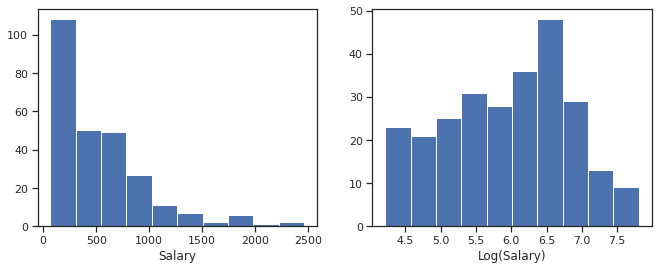

In [6]:
X = hitters[['Years', 'Hits']].values
y = np.log(hitters.Salary.values)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(hitters.Salary.values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

In [7]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

### Figure 8.1

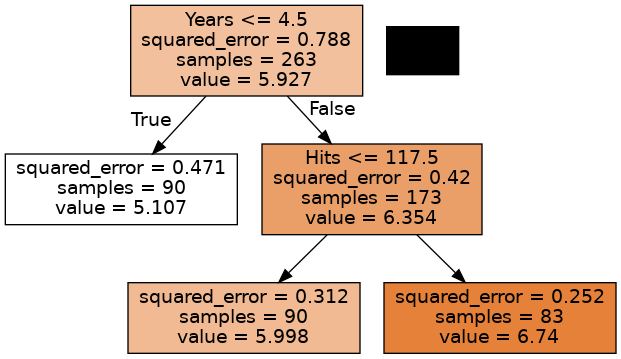

In [8]:
graph, = print_tree(regr, features=['Years', 'Hits'])
Image(graph.create_png())

###  Figure 8.2

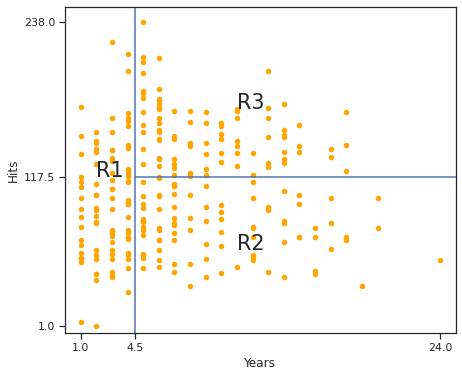

In [9]:
hitters.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

### FIGURE 8.4 

Pruning
This is currently not supported in scikit-learn. See first point under 'disadvantages of decision trees in the <A href='http://scikit-learn.github.io/dev/modules/tree.html#'>documentation</A>. Implementation has been <A href='https://github.com/scikit-learn/scikit-learn/pull/941'>discussed</A> but Random Forests have better predictive qualities than a single pruned tree anyway if I understand correctly.
    

In [10]:
x= hitters.drop(['League', 'Division', 'NewLeague','Salary'], axis=1)
hitters.columns
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.5, random_state =0)

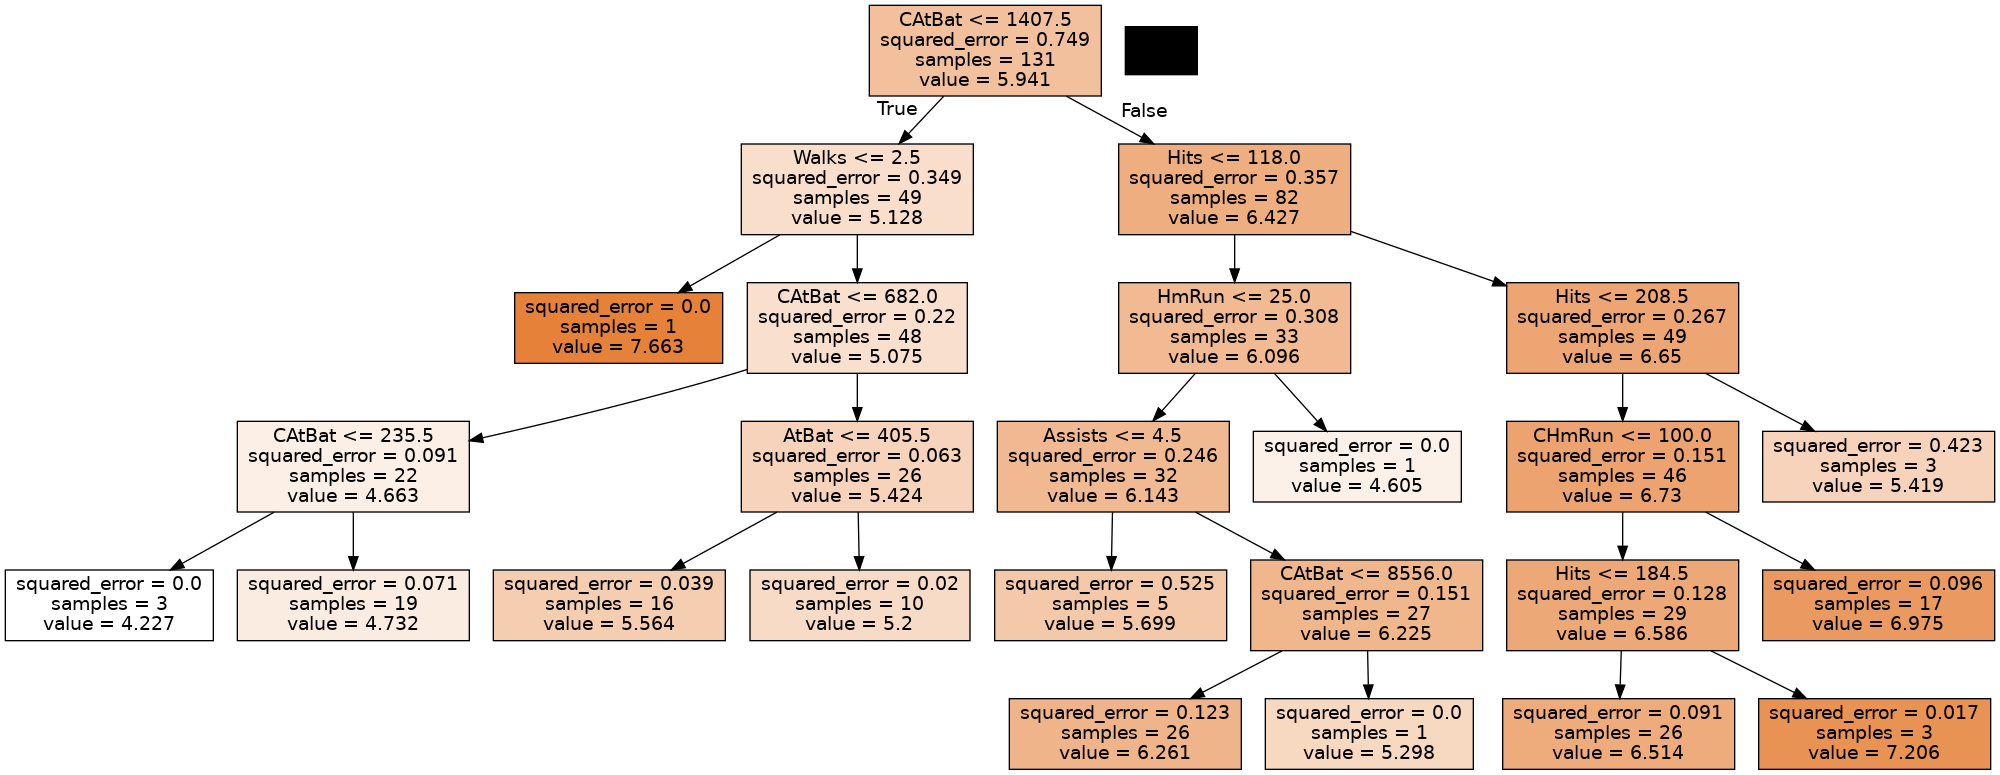

In [11]:
regressor2 = DecisionTreeRegressor(random_state=0 , min_samples_split=20, max_depth=5)
regressor2.fit(x_train, y_train)
graph, = print_tree(regressor2, features=x.columns)
Image(graph.create_png())

### Figure 8.5 (TODO)

In [12]:
mse =[]
tree_size=  np.arange(1,11)
for i in tree_size:
    regressor3 = DecisionTreeRegressor(random_state = 0, max_depth=i, max_features=9)
    mod= regressor3.fit(x_train, y_train)
    pred = mod.predict(x_test)
    mse.append(mean_squared_error(pred, y_test))


Text(0, 0.5, 'Mean Squared Error')

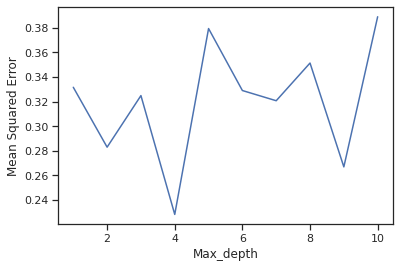

In [13]:
plt.plot(tree_size, mse)
plt.xlabel('Max_depth')
plt.ylabel('Mean Squared Error')

##this graph looks very weird. It was supposed to be a downward line.

### 8.1.2 Classification Trees

### Figure 8.6 (TODO)

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [14]:
df2 = pd.read_csv('https://www.statlearning.com/s/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


In [15]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [16]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [17]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X2,y2)

DecisionTreeClassifier(max_features=3, max_leaf_nodes=6)

In [18]:
clf.score(X2,y2)

0.797979797979798

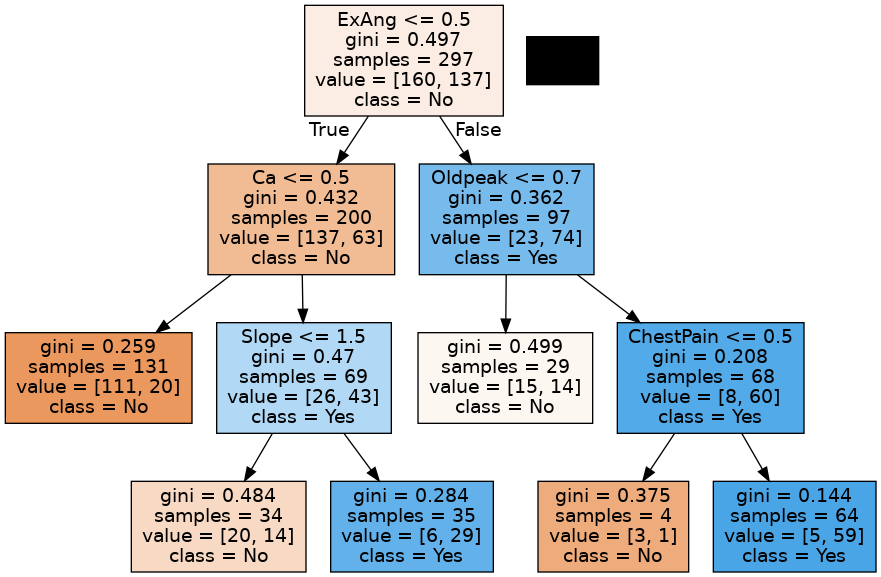

In [19]:
graph2, = print_tree(clf, features=X2.columns, class_names=['No', 'Yes'])
Image(graph2.create_png())

### Figure 8.8 (TODO)

### Figure 8.9 (TODO)

### Figure 8.10 (TODO)

### Figure 8.11 (TODO)

### Figure 8.13 (TODO)